Student: OUARDIGHI Omar \
Github Repo  

In [7]:
import networkx as nx
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, roc_curve
import matplotlib.pyplot as plt
from node2vec import Node2Vec

In [2]:
G_fb = nx.read_edgelist("Group7/Facebook-Ego/1912.edges", create_using = nx.Graph(), nodetype = int)
num_edges = G_fb.number_of_edges()
print("Number of edges:", num_edges)

Number of edges: 1235


## Edge Spilitting

In [3]:
# Function to create negative samples (pairs of nodes not connected)
random.seed(0)
def get_negative_edges(graph, num_neg_samples):
    negative_edges = []
    all_nodes = list(graph.nodes())
    while len(negative_edges) < num_neg_samples:
        node1, node2 = random.sample(all_nodes, 2)
        if not graph.has_edge(node1, node2):
            negative_edges.append((node1, node2))
    return negative_edges


In [4]:
# Split the edges into training and test sets (90% train, 10% test)
train_edges, test_edges = train_test_split(list(G_fb.edges()), test_size=0.1, random_state=42)

# Remove test edges from the graph
G_train = G_fb.copy()
G_train.remove_edges_from(test_edges)

# Generate negative samples for training and testing
negative_edges_train = get_negative_edges(G_train, len(train_edges))
negative_edges_test = get_negative_edges(G_fb, len(test_edges))


In [5]:
# Combine positive and negative samples for training and testing
train_edges_with_labels = [(edge, 1) for edge in train_edges] + [(edge, 0) for edge in negative_edges_train]
test_edges_with_labels = [(edge, 1) for edge in test_edges] + [(edge, 0) for edge in negative_edges_test]

## Generate node2vec embeddings


In [6]:
# Generate node2vec embeddings
node2vec = Node2Vec(G_fb, dimensions=64, walk_length=30, num_walks=200, workers=1)  
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:09<00:00, 20.25it/s]


In [8]:
# Create feature vectors for the training set
X_train = [np.concatenate([model.wv[str(edge[0])], model.wv[str(edge[1])]]) for edge, label in train_edges_with_labels]
y_train = [label for edge, label in train_edges_with_labels]

# Create feature vectors for the test set
X_test = [np.concatenate([model.wv[str(edge[0])], model.wv[str(edge[1])]]) for edge, label in test_edges_with_labels]
y_test = [label for edge, label in test_edges_with_labels]


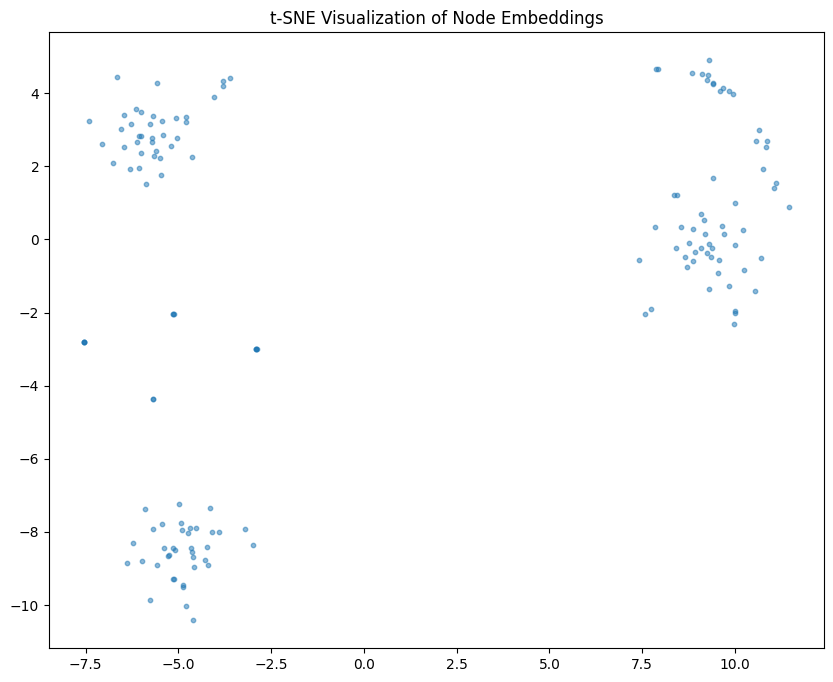

In [21]:
# Get node embeddings
node_embeddings = np.array([model.wv[str(node)] for node in G_fb.nodes()])

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Visualize the node embeddings
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], s=10, alpha=0.5)
plt.title('t-SNE Visualization of Node Embeddings')
plt.show()

## Modeling

In [23]:
model_lr = LogisticRegression( max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)

# Predictions
y_pred = model_lr.predict(X_test)
y_pred_proba = model_lr.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("AUROC:", auroc)
print("Precision:", precision)


Accuracy: 0.7298387096774194
AUROC: 0.8068418314255984
Precision: 0.728


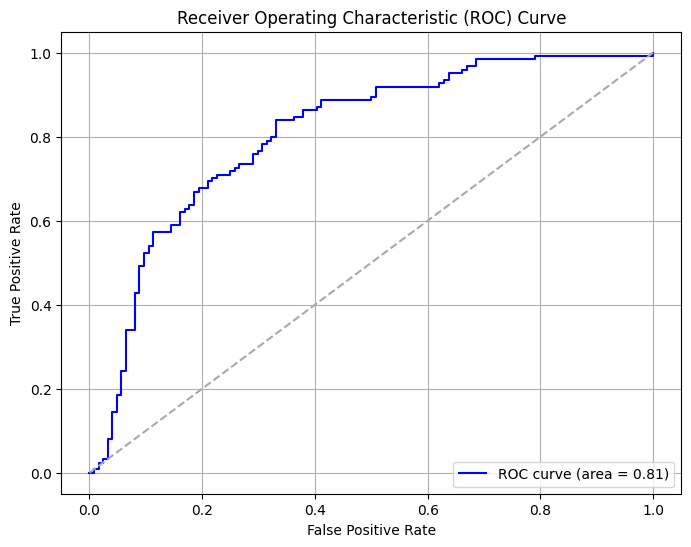

In [24]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [25]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

# Predictions
y_pred = model_rf.predict(X_test)
y_pred_proba = model_rf.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("AUROC:", auroc)
print("Precision:", precision)

Accuracy: 0.8790322580645161
AUROC: 0.9707336108220604
Precision: 0.9351851851851852


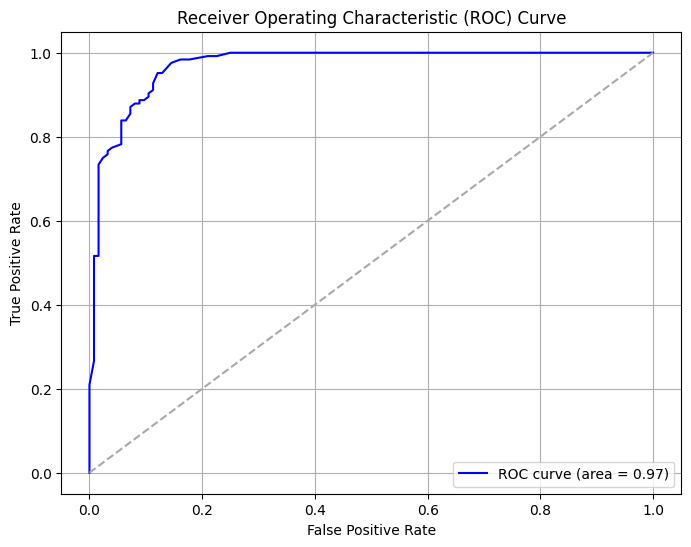

In [26]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [27]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train, y_train)

# Predictions
y_pred = model_xgb.predict(X_test)
y_pred_proba = model_xgb.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("AUROC:", auroc)
print("Precision:", precision)

Accuracy: 0.8911290322580645
AUROC: 0.9703433922996878
Precision: 0.9145299145299145


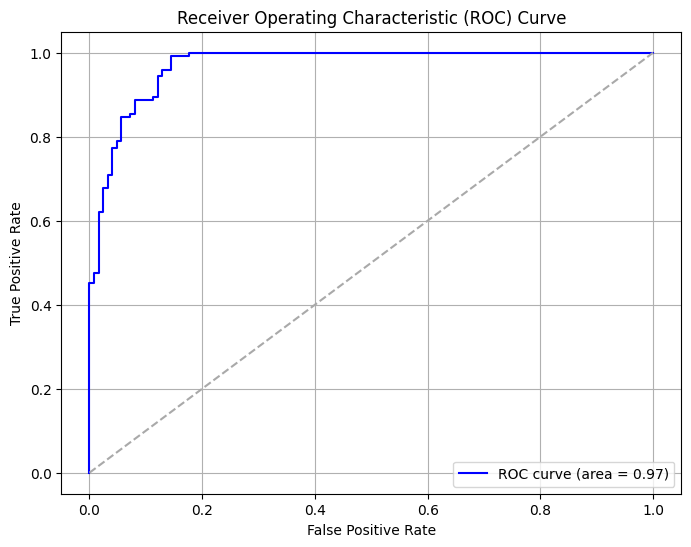

In [28]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()